# NLP 1 - EX4

*imports*

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
from torch.utils.data import DataLoader, TensorDataset, Dataset
import operator
import pickle
import tqdm
import matplotlib.pyplot as plt
import os
import random
from google.colab import drive

***connect to drive***

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Loader Helper Functions**

In [3]:
POSITIVE_SENTIMENT = 1.
NEGATIVE_SENTIMENT = 0.
NEUTRAL_SENTIMENT = -1.


SENTIMENT_NAMES = {
    POSITIVE_SENTIMENT: "Positive",
    NEUTRAL_SENTIMENT: "Neutral",
    NEGATIVE_SENTIMENT: "Negative"
}
SENTS_PATH = "SOStr.txt"
TREES_PATH = "STree.txt"
DICT_PATH = "dictionary.txt"
LABELS_path = "sentiment_labels.txt"

In [4]:
def get_sentiment_class_from_val(sentiment_val: float):
    if sentiment_val <= 0.4:
        return NEGATIVE_SENTIMENT
    elif sentiment_val >= 0.6:
        return POSITIVE_SENTIMENT
    else:
        return NEUTRAL_SENTIMENT

class SentimentTreeNode(object):
    def __init__(self, text: list, sentiment_val: float, min_token_idx: int, children=[], parent=None):
        self.text = text
        self.sentiment_val = sentiment_val
        self.min_token_idx = min_token_idx
        self.sentiment_class = get_sentiment_class_from_val(sentiment_val)
        self.children = children
        self.parent = parent


class Sentence(object):
    """
    Represents a sentence in sentiment tree bank.
    You can access the sentence text by sent.text
    This will give you a list of tokens (strings) in the order that they appear in the sentence.
    sent.sentiment_class is the coding of the annotated sentiment polarity of the sentence.
    sent.sentiment_val is the exact annotated sentiment value in the range [0,1]
    """
    def __init__(self, sentence_root: SentimentTreeNode):
        self.root = sentence_root
        self.text = sentence_root.text
        self.sentiment_class = sentence_root.sentiment_class
        self.sentiment_val = sentence_root.sentiment_val

    def _get_leaves_recursively(self, cur_root):
        if len(cur_root.children) == 0:
            return [cur_root]
        else:
            cur_leaves = []
            for child in cur_root.children:
                cur_leaves += self._get_leaves_recursively(child)
            return cur_leaves

    def get_leaves(self):
        return self._get_leaves_recursively(self.root)

    def __repr__(self):
        return " ".join(self.text) + " | " + SENTIMENT_NAMES[self.sentiment_class] + " | " + str(self.sentiment_val)



class SentimentTreeBank(object):
    """
    The main object that represents the stanfordSentimentTreeBank dataset. Can be used to access the
    examples and some other utilities.
    """
    def __init__(self, path="/content/drive/MyDrive/CS/NLP/ex4/stanfordSentimentTreebank", split_ratios=(0.8,0.1,0.1), split_words=True):
        """

        :param path: relative or absolute path to the datset directory
        :param split_ratios: split ratios for train, validation and test. please do not change!
        :param split_words: whether to split tokens with "-" and "/" symbols. please do not change!
        """
        self._base_path = path
        self.split_words = split_words
        sentences = self._read_sentences()
        self.sentences = self._build_dataset(sentences)
        if self.split_words:
            for sent in self.sentences:
                leaves = sent.get_leaves()
                for node in leaves:
                    node_text = node.text
                    splitted = node_text[0].split("-")
                    splitted_final = []
                    for s in splitted:
                        splitted_final.extend(s.split("\\/"))
                    if len(splitted_final) > 1 and all([len(s) > 0 for s in splitted_final]):
                        leaves = [SentimentTreeNode([s], node.sentiment_val,
                                                    min_token_idx=node.min_token_idx, parent=node) for
                                  s in splitted_final]
                        node.text = splitted_final
                        node.children = leaves
                        cur_parent = node.parent
                        while cur_parent != None:
                            cur_parent.text = []
                            for child in cur_parent.children:
                                cur_parent.text.extend(child.text)
                            cur_parent = cur_parent.parent
                sent.text = sent.root.text


        assert len(split_ratios) == 3
        assert sum(split_ratios) == 1
        self.split_ratios = split_ratios



    def _read_sentences(self):
        sentences = []
        with open(os.path.join(self._base_path, SENTS_PATH), "r", encoding="utf-8") as f:
            lines = f.read().split("\n")
            for i, line in enumerate(lines):
                if len(line.strip()) == 0:
                    continue
                line_content = line.strip()
                tokens = line_content.split("|")
                tokens = [t.lower().replace("-lrb-","(").replace("-rrb-", ")") for t in tokens]
                sentences.append(tokens)
        return sentences

    def _build_dataset(self, sentences):
        phrases_dictionary = {}

        # extract phrases
        with open(os.path.join(self._base_path, DICT_PATH), "r", encoding="utf-8") as f:
            lines = f.read().split("\n")[:-1]
            for line in lines:
                phrase, phrase_id = line.strip().split("|")
                phrases_dictionary[phrase.lower().replace("-lrb-","(").replace("-rrb-", ")")] = int(phrase_id)

        # extract labels
        with open(os.path.join(self._base_path, LABELS_path), "r",  encoding="utf-8") as f:
            lines = [l.strip().split("|") for l in f.read().split("\n")[1:-1]]
            labels_dict = {int(l[0]): float(l[1]) for l in lines}


        def get_val_from_phrase(phrase_tokens_list):
            try:
                return labels_dict[phrases_dictionary[" ".join(phrase_tokens_list)]]
            except:
                print("couldn't find key!")

        # load the sentences tree structures
        tree_pointers = []
        with open(os.path.join(self._base_path, TREES_PATH), "r") as f:
            for line in f.readlines():
                sent_pointers = [int(p) for p in line.strip().split("|")]
                tree_pointers.append(sent_pointers)
        assert len(tree_pointers) == len(sentences)

        # create Sentence instances with tree of SentimentTreeNodes
        labeled_sentences = []
        for sent, sent_pointers in zip(sentences, tree_pointers):
            try:

                children_dict = {i: [] for i in range(len(sent_pointers))}
                for i, p in enumerate(sent_pointers):
                    if i < len(sent):
                        node_text = [sent[i]]
                        node = SentimentTreeNode(text=node_text, sentiment_val=get_val_from_phrase(node_text),
                                                 min_token_idx=i)
                    else:
                        children = children_dict[i]
                        children = sorted(children, key= lambda n: n.min_token_idx)
                        node_text = []
                        for child in children:
                            node_text.extend(child.text)
                        node = SentimentTreeNode(text=node_text, sentiment_val=get_val_from_phrase(node_text),
                                                 children=children, min_token_idx=children[0].min_token_idx)
                        for child in children:
                            child.parent = node
                    if p > 0:
                        children_dict[p - 1].append(node)
                    last_node = node
                new_sentence = Sentence(last_node)
                if new_sentence.sentiment_class == NEUTRAL_SENTIMENT:
                    continue
                labeled_sentences.append(new_sentence)
            except Exception as e:
                raise e
                print("couldn't parse sentence!")
                print(sent)
        random.Random(1).shuffle(labeled_sentences) # shuffle but with the same shuffle each time
        return labeled_sentences

    def get_train_set(self):
        """
        :return: list of Sentence instances for the train part of the dataset
        """
        if not hasattr(self, "_train_set"):
            self._train_set = self.sentences[:int(self.split_ratios[0] * len(self.sentences))]
        return self._train_set

    def _extract_all_phrases(self, root):
        phrases = [Sentence(root)] if root.sentiment_class != NEUTRAL_SENTIMENT else []
        if len(root.text) == 1:
            return []
        for child in root.children:
            phrases += self._extract_all_phrases(child)
        return phrases

    def get_train_set_phrases(self):
        """
        :return: list of Sentence instances for the train part of the dataset including all sub-phrases
        """
        if not hasattr(self, "_train_set_phrases"):
            train_set = self.get_train_set()
            train_set_phrases = []
            for sent in train_set:
                train_set_phrases += self._extract_all_phrases(sent.root)
            self._train_set_phrases = train_set_phrases
        return self._train_set_phrases

    def get_test_set(self):
        """
        :return: list of Sentence instances for the test part of the dataset
        """
        if not hasattr(self, "_test_set"):
            begin_index = int(self.split_ratios[0] * len(self.sentences))
            end_index = int(sum(self.split_ratios[:2]) * len(self.sentences))
            self._test_set = self.sentences[begin_index:end_index]
        return self._test_set

    def get_validation_set(self):
        """
        :return: list of Sentence instances for the validation part of the dataset
        """
        if not hasattr(self, "_validation_set"):
            self._validation_set = self.sentences[int(sum(self.split_ratios[:2]) * len(self.sentences)):]
        return self._validation_set

    def get_train_word_counts(self):
        """
        :return: dictionary of all words in the train set with their frequency in the train set.
        """
        if not hasattr(self, "_train_word_counts"):
            word_counts = {}
            for sent in self.get_train_set():
                for word_node in sent.get_leaves():
                    assert len(word_node.text) == 1
                    word_text = word_node.text[0]
                    if word_text in word_counts:
                        word_counts[word_text] += 1
                    else:
                        word_counts[word_text] = 1
            self._train_word_counts = word_counts

        return self._train_word_counts

    def get_word_counts(self):
        """
        :return: dictionary of all words in the dataset with their frequency in the whole dataset.
        """
        if not hasattr(self, "_word_counts"):
            word_counts = {}
            for sent in self.sentences:
                for word_node in sent.get_leaves():
                    assert len(word_node.text) == 1
                    word_text = word_node.text[0]
                    if word_text in word_counts:
                        word_counts[word_text] += 1
                    else:
                        word_counts[word_text] = 1
            self._word_counts = word_counts

        return self._word_counts



def get_negated_polarity_examples(sentences_list, num_examples=None, choose_random=False):
    """
    Returns the indices of the sentences in sentences_list which have subphrase in the second level with
    sentiment polarity different than the whole sentence polarity.
    :param sentences_list: list of Sentence objects
    :param num_examples: number of examples to return, if None all of them are returned
    :param choose_random: relevant only if num_examples is lower than the number of exisitng negated
    polarity examples in sentences_list
    """

    if num_examples is None:
        num_examples = len(sentences_list) # take all possible sentences

    def is_polarized(sent: Sentence):
        if sent.sentiment_class == NEUTRAL_SENTIMENT:
            return False
        else:
            root_polarity = sent.sentiment_class
            for child in sent.root.children:
                if child.sentiment_class == 1 - root_polarity:
                    return True
            return False
    indexed_senteces = list(enumerate(sentences_list))
    negated_sentences = list(filter(lambda s: is_polarized(s[1]), indexed_senteces))
    negated_sentences_indices = [i for i,s in negated_sentences]
    if len(negated_sentences) <= num_examples:
        return negated_sentences_indices
    else:
        if choose_random:
            random.shuffle(negated_sentences_indices)
        return negated_sentences_indices[:num_examples]


def get_sentiment_words(sent: Sentence):
    sent_polarity = sent.sentiment_class
    return [node for node in sent.get_leaves() if node.sentiment_class == sent_polarity]


def get_rare_words_examples(sentences_list, dataset: SentimentTreeBank,
                            num_sentences=50):
    """
    Computes for each sentence in sentences the maximal train frequency of sentiment word, where sentiment
    word is a word which is labeled with either positive or negative sentiment value, and returns the
    indices of the <num_sentences> sentences with lowest value.
    :param sentences_list: list of Sentence objects
    :param dataset: the SentimentTreebank datset object
    :param num_sentences: number of sentences to return
    :return: list of ints representing the indices of the chosen sentences out of the input sentences_list
    """
    word_counts = dataset.get_train_word_counts()

    def get_count(word_node: SentimentTreeNode):
        word_text = word_node.text[0]
        if word_text in word_counts:
            return word_counts[word_text]
        else:
            return 0
    indexed_sentences = list(enumerate(sentences_list))
    indexed_sentences = list(filter(lambda s: len(get_sentiment_words(s[1])) > 0, indexed_sentences))
    indexed_sentences = sorted(indexed_sentences, key= lambda s: max([get_count(node) for node in
                                                                      get_sentiment_words(s[1])]))
    indices = [i for i,s in indexed_sentences]
    return indices[:num_sentences]

# **exercise functions**

# ------------------------------------------- Constants ----------------------------------------


In [5]:
SEQ_LEN = 52
W2V_EMBEDDING_DIM = 300

ONEHOT_AVERAGE = "onehot_average"
W2V_AVERAGE = "w2v_average"
W2V_SEQUENCE = "w2v_sequence"

TRAIN = "train"
VAL = "val"
TEST = "test"

# ------------------------------------------ Helper methods and classes --------------------------


In [6]:
def get_available_device():
    """
    Allows training on GPU if available. Can help with running things faster when a GPU with cuda is
    available but not a must...
    Given a device, one can use module.to(device)
    and criterion.to(device) so that all the computations will be done on the GPU.
    """
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def save_pickle(obj, path):
    with open(path, "wb") as f:
        pickle.dump(obj, f)


def load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)


def save_model(model, path, epoch, optimizer):
    """
    Utility function for saving checkpoint of a model, so training or evaluation can be executed later on.
    :param model: torch module representing the model
    :param optimizer: torch optimizer used for training the module
    :param path: path to save the checkpoint into
    """
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}, path)


def load(model, path, optimizer):
    """
    Loads the state (weights, paramters...) of a model which was saved with save_model
    :param model: should be the same model as the one which was saved in the path
    :param path: path to the saved checkpoint
    :param optimizer: should be the same optimizer as the one which was saved in the path
    """
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return model, optimizer, epoch

# ------------------------------------------ Data utilities ----------------------------------------


In [7]:
def load_word2vec():
    """ Load Word2Vec Vectors
        Return:
            wv_from_bin: All 3 million embeddings, each lengh 300
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300")
    vocab = list(wv_from_bin.key_to_index.keys())
    print(wv_from_bin.key_to_index[vocab[0]])
    print("Loaded vocab size %i" % len(vocab))
    return wv_from_bin


def create_or_load_slim_w2v(words_list, cache_w2v=False):
    """
    returns word2vec dict only for words which appear in the dataset.
    :param words_list: list of words to use for the w2v dict
    :param cache_w2v: whether to save locally the small w2v dictionary
    :return: dictionary which maps the known words to their vectors
    """
    w2v_path = "w2v_dict.pkl"
    if not os.path.exists(w2v_path):
        full_w2v = load_word2vec()
        w2v_emb_dict = {k: full_w2v[k] for k in words_list if k in full_w2v}
        if cache_w2v:
            save_pickle(w2v_emb_dict, w2v_path)
    else:
        w2v_emb_dict = load_pickle(w2v_path)
    return w2v_emb_dict


def get_w2v_average(sent, word_to_vec, embedding_dim):
    """
    This method gets a sentence and returns the average word embedding of the words consisting
    the sentence.
    :param sent: the sentence object
    :param word_to_vec: a dictionary mapping words to their vector embeddings
    :param embedding_dim: the dimension of the word embedding vectors
    :return The average embedding vector as numpy ndarray.
    """
    # Initialize a zero vector for the average embedding
    avg_embedding = np.zeros(embedding_dim, dtype=np.float32)

    # Count valid words (those that exist in word_to_vec)
    valid_words = 0

    for word in sent.text:
        if word in word_to_vec:
            avg_embedding += word_to_vec[word]
            valid_words += 1

    # If there are valid words, compute the average
    if valid_words > 0:
        avg_embedding /= valid_words

    return avg_embedding




def get_one_hot(size, ind):
    """
    this method returns a one-hot vector of the given size, where the 1 is placed in the ind entry.
    :param size: the size of the vector
    :param ind: the entry index to turn to 1
    :return: numpy ndarray which represents the one-hot vector
    """
    vec = np.zeros(size, dtype=np.float32)
    vec[ind] = 1.0
    return vec


def average_one_hots(sent, word_to_ind):
    """
    this method gets a sentence, and a mapping between words to indices, and returns the average
    one-hot embedding of the tokens in the sentence.
    :param sent: a sentence object.
    :param word_to_ind: a mapping between words to indices
    :return:
    """
    # We'll store the sum of the one-hot vectors here
    vocab_size = len(word_to_ind)
    sum_vec = np.zeros(vocab_size, dtype=np.float32)

    # Count how many valid tokens we have (i.e., tokens that appear in word_to_ind)
    valid_tokens = 0

    for word in sent.text:
        if word in word_to_ind:
            idx = word_to_ind[word]
            # increment the sum_vec at the index
            sum_vec += get_one_hot(vocab_size, idx)
            valid_tokens += 1

    # Compute the average if we had at least one valid token
    if valid_tokens > 0:
        sum_vec /= valid_tokens

    return sum_vec


def get_word_to_ind(words_list):
    """
    this function gets a list of words, and returns a mapping between
    words to their index.
    :param words_list: a list of words
    :return: the dictionary mapping words to the index
    """
    return {word: idx for idx, word in enumerate(words_list)}


def sentence_to_embedding(sent, word_to_vec, seq_len, embedding_dim=300):
    """
    this method gets a sentence and a word to vector mapping, and returns a list containing the
    words embeddings of the tokens in the sentence.
    :param sent: a sentence object
    :param word_to_vec: a word to vector mapping.
    :param seq_len: the fixed length for which the sentence will be mapped to.
    :param embedding_dim: the dimension of the w2v embedding
    :return: numpy ndarray of shape (seq_len, embedding_dim) with the representation of the sentence
    """
    # Initialize a zero matrix for the fixed-length sentence representation
    embedding_matrix = np.zeros((seq_len, embedding_dim), dtype=np.float32)

    # Map words to embeddings and keep count of valid words
    for i, word in enumerate(sent.text[:seq_len]):  # Truncate if sentence is longer than seq_len
        if word in word_to_vec:
            embedding_matrix[i] = word_to_vec[word]

    return embedding_matrix



class OnlineDataset(Dataset):
    """
    A pytorch dataset which generates model inputs on the fly from sentences of SentimentTreeBank
    """

    def __init__(self, sent_data, sent_func, sent_func_kwargs):
        """
        :param sent_data: list of sentences from SentimentTreeBank
        :param sent_func: Function which converts a sentence to an input datapoint
        :param sent_func_kwargs: fixed keyword arguments for the state_func
        """
        self.data = sent_data
        self.sent_func = sent_func
        self.sent_func_kwargs = sent_func_kwargs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sent = self.data[idx]
        sent_emb = self.sent_func(sent, **self.sent_func_kwargs)
        sent_label = sent.sentiment_class
        return sent_emb, sent_label


class DataManager():
    """
    Utility class for handling all data management task. Can be used to get iterators for training and
    evaluation.
    """

    def __init__(self, data_type=ONEHOT_AVERAGE, use_sub_phrases=True, dataset_path="/content/drive/MyDrive/CS/NLP/ex4/stanfordSentimentTreebank", batch_size=50,
                 embedding_dim=None):
        """
        builds the data manager used for training and evaluation.
        :param data_type: one of ONEHOT_AVERAGE, W2V_AVERAGE and W2V_SEQUENCE
        :param use_sub_phrases: if true, training data will include all sub-phrases plus the full sentences
        :param dataset_path: path to the dataset directory
        :param batch_size: number of examples per batch
        :param embedding_dim: relevant only for the W2V data types.
        """

        # load the dataset
        self.sentiment_dataset = SentimentTreeBank(dataset_path, split_words=True)
        # map data splits to sentences lists
        self.sentences = {}
        if use_sub_phrases:
            self.sentences[TRAIN] = self.sentiment_dataset.get_train_set_phrases()
        else:
            self.sentences[TRAIN] = self.sentiment_dataset.get_train_set()

        self.sentences[VAL] = self.sentiment_dataset.get_validation_set()
        self.sentences[TEST] = self.sentiment_dataset.get_test_set()

        # map data splits to sentence input preperation functions
        words_list = list(self.sentiment_dataset.get_word_counts().keys())
        if data_type == ONEHOT_AVERAGE:
            self.sent_func = average_one_hots
            self.sent_func_kwargs = {"word_to_ind": get_word_to_ind(words_list)}
        elif data_type == W2V_SEQUENCE:
            self.sent_func = sentence_to_embedding

            self.sent_func_kwargs = {"seq_len": SEQ_LEN,
                                     "word_to_vec": create_or_load_slim_w2v(words_list),
                                     "embedding_dim": embedding_dim
                                     }
        elif data_type == W2V_AVERAGE:
            self.sent_func = get_w2v_average
            words_list = list(self.sentiment_dataset.get_word_counts().keys())
            self.sent_func_kwargs = {"word_to_vec": create_or_load_slim_w2v(words_list),
                                     "embedding_dim": embedding_dim
                                     }
        else:
            raise ValueError("invalid data_type: {}".format(data_type))
        # map data splits to torch datasets and iterators
        self.torch_datasets = {k: OnlineDataset(sentences, self.sent_func, self.sent_func_kwargs) for
                               k, sentences in self.sentences.items()}
        self.torch_iterators = {k: DataLoader(dataset, batch_size=batch_size, shuffle=k == TRAIN)
                                for k, dataset in self.torch_datasets.items()}

    def get_torch_iterator(self, data_subset=TRAIN):
        """
        :param data_subset: one of TRAIN VAL and TEST
        :return: torch batches iterator for this part of the datset
        """
        return self.torch_iterators[data_subset]

    def get_labels(self, data_subset=TRAIN):
        """
        :param data_subset: one of TRAIN VAL and TEST
        :return: numpy array with the labels of the requested part of the datset in the same order of the
        examples.
        """
        return np.array([sent.sentiment_class for sent in self.sentences[data_subset]])

    def get_input_shape(self):
        """
        :return: the shape of a single example from this dataset (only of x, ignoring y the label).
        """
        return self.torch_datasets[TRAIN][0][0].shape

# ------------------------------------ Models ----------------------------------------------------

In [8]:
class LSTM(nn.Module):
    """
    An LSTM for sentiment analysis with architecture as described in the exercise description.
    """
    def __init__(self, embedding_dim, hidden_dim, n_layers, dropout):
        super(LSTM, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Define the BiLSTM layer
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            bidirectional=True,
            batch_first=True
        )

        # Define a dropout layer
        self.dropout = nn.Dropout(p=dropout)

        # Define the final linear layer
        self.fc = nn.Linear(hidden_dim * 2, 1)  # BiLSTM doubles the hidden size due to bidirectionality

    def forward(self, text):
        """
        Forward pass through the LSTM.
        :param text: Tensor of shape [batch_size, seq_len, embedding_dim]
        :return: Tensor of shape [batch_size], the raw logits
        """
        # Pass through the LSTM
        lstm_out, _ = self.lstm(text)

        # Extract the last hidden state from both directions
        last_hidden_state = torch.cat((lstm_out[:, -1, :self.hidden_dim], lstm_out[:, 0, self.hidden_dim:]), dim=1)

        # Apply dropout
        dropped = self.dropout(last_hidden_state)

        # Pass through the fully connected layer
        logits = self.fc(dropped).squeeze(1)  # Remove extra dimension for binary output
        return logits

    def predict(self, text):
        """
        Compute predictions based on the input text.
        :param text: Tensor of shape [batch_size, seq_len, embedding_dim]
        :return: Tensor of shape [batch_size], with 0/1 predictions
        """
        logits = self.forward(text)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).long()
        return preds


class LogLinear(nn.Module):
    """
    general class for the log-linear models for sentiment analysis.
    """
    def __init__(self, embedding_dim):
        """
        :param embedding_dim: dimension of the average embedding input
        """
        super(LogLinear, self).__init__()
        # A single linear layer that outputs a single score
        self.linear = nn.Linear(embedding_dim, 1)

    def forward(self, x):
        """
        :param x: A tensor of shape [batch_size, embedding_dim]
        :return: A tensor of shape [batch_size], the raw logits
        """
        logits = self.linear(x).squeeze(1)  # squeeze to get shape [batch_size]
        return logits

    def predict(self, x):
        """
        Computes the forward pass, applies a sigmoid, and thresholds at 0.5
        to obtain a binary classification (0 or 1).

        :param x: A tensor of shape [batch_size, embedding_dim]
        :return: A tensor of shape [batch_size], with 0/1 predictions
        """
        logits = self.forward(x)  # raw logits
        probs = torch.sigmoid(logits)  # convert logits to probabilities
        preds = (probs >= 0.5).long()  # threshold at 0.5
        return preds


# ------------------------- training functions -------------


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def binary_accuracy(preds, y):
    """
    This method returns tha accuracy of the predictions, relative to the labels.
    You can choose whether to use numpy arrays or tensors here.
    :param preds: a vector of predictions
    :param y: a vector of true labels
    :return: scalar value - (<number of accurate predictions> / <number of examples>)
    """
    # Convert predictions to binary by thresholding at 0.5
    preds_binary = (preds >= 0.5).astype(int)

    # Count how many predictions match the true labels
    correct = (preds_binary == y).sum()

    # Calculate the accuracy
    accuracy = correct / len(y)
    return accuracy


def train_epoch(model, data_iterator, optimizer, criterion):
    """
    This method operates one epoch (pass over the whole train set) of training of the given model,
    and returns the accuracy and loss for this epoch
    :param model: the model we're currently training
    :param data_iterator: an iterator, iterating over the training data for the model.
    :param optimizer: the optimizer object for the training process.
    :param criterion: the criterion object for the training process.
    """

    # Put the model in training mode
    model.train()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Iterate over all batches in the training data
    for inputs, labels in data_iterator:
        # Move inputs and labels to the device (GPU/CPU) if necessary
        inputs, labels = inputs.to(device), labels.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass: get logits from the model
        logits = model(inputs)

        # Compute the loss
        loss = criterion(logits, labels)

        # Backward pass: compute gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate loss (multiplied by batch size for correct averaging later)
        batch_size = labels.size(0)
        total_loss += loss.item() * batch_size

        # Convert logits to predictions for accuracy
        preds = (torch.sigmoid(logits) >= 0.5).long()

        # Compare predictions with true labels
        correct = (preds == labels).sum().item()
        total_correct += correct
        total_samples += batch_size

    # Compute average loss and accuracy over the epoch
    average_loss = total_loss / total_samples
    average_accuracy = total_correct / total_samples

    return average_loss, average_accuracy


def evaluate(model, data_iterator, criterion):
    """
    evaluate the model performance on the given data
    :param model: one of our models..
    :param data_iterator: torch data iterator for the relevant subset
    :param criterion: the loss criterion used for evaluation
    :return: tuple of (average loss over all examples, average accuracy over all examples)
    """
    # Set model to evaluation mode
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in data_iterator:
            # Move data to the appropriate device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass: compute logits
            logits = model(inputs)

            # Compute loss
            loss = criterion(logits, labels)

            # Accumulate total loss
            batch_size = labels.size()[0]
            total_loss += loss.item() * batch_size

            # Convert logits to predictions
            preds = (torch.sigmoid(logits) >= 0.5).long()

            # Calculate number of correct predictions
            correct = (preds == labels).sum().item()
            total_correct += correct
            total_samples += batch_size

    # Compute average loss and accuracy
    average_loss = total_loss / total_samples
    average_accuracy = total_correct / total_samples

    return average_loss, average_accuracy


def get_predictions_for_data(model, data_iter):
    """
    This function should iterate over all batches of examples from data_iter and return all of the models
    predictions as a numpy ndarray or torch tensor (or list if you prefer). the prediction should be in the
    same order of the examples returned by data_iter.
    :param model: one of the models you implemented in the exercise
    :param data_iter: torch iterator as given by the DataManager
    :return:
    """
    model.eval()  # Ensure the model is in evaluation mode
    all_preds = []

    # Disable gradient tracking for evaluation
    with torch.no_grad():
        for inputs, _ in data_iter:

            inputs = inputs.to(device)

            # Use the model's `predict` method to get discrete predictions
            batch_preds = model.predict(inputs)  # shape: [batch_size]

            # Optionally move predictions to CPU if you're on GPU
            all_preds.append(batch_preds.cpu())

    # Concatenate all predictions into a single 1D tensor
    all_preds = torch.cat(all_preds, dim=0)

    # Return as a PyTorch tensor or convert to numpy
    # return all_preds            # as torch tensor
    return all_preds.numpy()      # as numpy array


def train_model(model, data_manager, n_epochs, lr, weight_decay=0.):
    """
    Runs the full training procedure for the given model. The optimization should be done using the Adam
    optimizer with all parameters but learning rate and weight decay set to default.
    :param model: module of one of the models implemented in the exercise
    :param data_manager: the DataManager object
    :param n_epochs: number of times to go over the whole training set
    :param lr: learning rate to be used for optimization
    :param weight_decay: parameter for l2 regularization
    """
    model = model.to(device)


    # 1) Set up the optimizer (Adam) and the loss function (BCEWithLogitsLoss for binary classification)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCEWithLogitsLoss()

    # 2) Prepare lists to store metrics across epochs
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # 3) For each epoch, train on the training set, then evaluate on the validation set
    for epoch in range(n_epochs):
        # --- Training ---
        train_iter = data_manager.get_torch_iterator(TRAIN)
        train_loss, train_acc = train_epoch(model, train_iter, optimizer, criterion)

        # --- Validation ---
        val_iter = data_manager.get_torch_iterator(VAL)
        val_loss, val_acc = evaluate(model, val_iter, criterion)

        # --- Store metrics ---
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Print current epoch metrics
        print(f"[Epoch {epoch+1}/{n_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # 4) Return the lists of metrics
    return train_losses, train_accuracies, val_losses, val_accuracies, optimizer


def train_log_linear_with_one_hot():
    """
    Here comes your code for training and evaluation of the log linear model with one hot representation.
    """
    # 1) Instantiate a DataManager set up for one-hot average embeddings
    data_manager = DataManager(
        data_type=ONEHOT_AVERAGE,  # one-hot average
        use_sub_phrases=True,  # include sub-phrases in training
        dataset_path="/content/drive/MyDrive/CS/NLP/ex4/stanfordSentimentTreebank",  # path to the dataset
        batch_size=64  # batch size
    )

    # 2) Determine the input dimension from data_manager
    input_dim = data_manager.get_input_shape()[0]

    # 3) Create the log-linear model (single linear layer expecting input_dim)
    model = LogLinear(embedding_dim=input_dim)

    # 4) Define hyperparameters for training
    n_epochs = 20
    lr = 0.01
    weight_decay = 0.001


    # 5) Train the model using train_model (which internally calls train_epoch & evaluate)
    train_losses, train_accs, val_losses, val_accs, optimizer = train_model(
        model=model,
        data_manager=data_manager,
        n_epochs=n_epochs,
        lr=lr,
        weight_decay=weight_decay
    )

    save_path = "/content/drive/MyDrive/CS/NLP/ex4/one_hot_log_linear.pth"

    save_model(model, save_path, n_epochs, optimizer)

    print(f"Model saved to {save_path}")


    # Return relevant info for plotting
    return model, train_losses, train_accs, val_losses, val_accs, data_manager

def train_log_linear_with_w2v():
    """
    Here comes your code for training and evaluation of the log linear model with word embeddings
    representation.
    """
    # 1) Instantiate a DataManager set up for Word2Vec average embeddings
    data_manager = DataManager(
        data_type=W2V_AVERAGE,  # Use Word2Vec average representation
        use_sub_phrases=True,  # Include sub-phrases in training
        dataset_path="/content/drive/MyDrive/CS/NLP/ex4/stanfordSentimentTreebank",  # Path to the dataset
        batch_size=64,  # Batch size for training
        embedding_dim=W2V_EMBEDDING_DIM  # Embedding dimension for Word2Vec
    )

    # 2) Determine the input dimension from the DataManager
    input_dim = data_manager.get_input_shape()[0]

    # 3) Create the log-linear model (a single linear layer expecting input_dim)
    model = LogLinear(embedding_dim=input_dim)

    # 4) Define hyperparameters for training
    n_epochs = 20  # Number of training epochs
    lr = 0.001  # Learning rate for the optimizer
    weight_decay = 0.001  # Weight decay for L2 regularization

    # 5) Train the model using train_model (defined earlier)
    train_losses, train_accuracies, val_losses, val_accuracies, optimizer = train_model(
        model=model,
        data_manager=data_manager,
        n_epochs=n_epochs,
        lr=lr,
        weight_decay=weight_decay
    )

    save_path = "/content/drive/MyDrive/CS/NLP/ex4/w2v_log_linear.pth"

    save_model(model, save_path, n_epochs, optimizer)

    print(f"Model saved to {save_path}")

    # Return the model and training/validation metrics for further analysis
    return model, train_losses, train_accuracies, val_losses, val_accuracies, data_manager



def train_lstm_with_w2v():
    """
    Here comes your code for training and evaluation of the LSTM model.
    """
    # Configuration
    hidden_dim = 100
    n_layers = 1
    dropout = 0.5
    seq_len = SEQ_LEN
    n_epochs = 4
    lr = 0.001
    weight_decay = 0.0001
    batch_size = 64

    # 1) Instantiate a DataManager set up for Word2Vec sequence embeddings
    data_manager = DataManager(
        data_type=W2V_SEQUENCE,  # Use Word2Vec sequence representation
        use_sub_phrases=True,  # Include sub-phrases in training
        dataset_path="/content/drive/MyDrive/CS/NLP/ex4/stanfordSentimentTreebank",  # Path to the dataset
        batch_size=batch_size,  # Batch size for training
        embedding_dim=W2V_EMBEDDING_DIM  # Embedding dimension for Word2Vec
    )

    # Initialize the LSTM model
    model = LSTM(embedding_dim=W2V_EMBEDDING_DIM, hidden_dim=hidden_dim, n_layers=n_layers, dropout=dropout)


    # 5) Train the model using train_model (defined earlier)
    train_losses, train_accuracies, val_losses, val_accuracies, optimizer = train_model(
        model=model,
        data_manager=data_manager,
        n_epochs=n_epochs,
        lr=lr,
        weight_decay=weight_decay
    )

    save_path = "/content/drive/MyDrive/CS/NLP/ex4/w2v_lstm.pth"

    save_model(model, save_path, n_epochs, optimizer)

    print(f"Model saved to {save_path}")

    # Return the model and training/validation metrics for further analysis
    return model, train_losses, train_accuracies, val_losses, val_accuracies, data_manager


Using device: cuda


***Plotting***

In [10]:
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # -- Plot Loss --
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title("Loss vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # -- Plot Accuracy --
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title("Accuracy vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

def report_test_performance(model, data_manager):
    """
    Evaluate the model on the test set and print the resulting loss and accuracy.
    """
    # 1) Retrieve the test iterator
    test_iter = data_manager.get_torch_iterator(TEST)

    # 2) Define the loss function
    criterion = nn.BCEWithLogitsLoss()

    # 3) Evaluate
    test_loss, test_acc = evaluate(model, test_iter, criterion)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    return test_loss, test_acc

In [11]:
def evaluate_special_subsets(model, data_manager):
    """
    Evaluate the model on special subsets like negated polarity examples and rare word examples.
    :param model: Trained model to evaluate.
    :param data_manager: DataManager object to fetch datasets.
    """
    print("Evaluating special subsets...")

    # Access the SentimentTreeBank instance
    sentiment_dataset = data_manager.sentiment_dataset

    # Retrieve the test set sentences
    test_sentences = sentiment_dataset.get_test_set()

    # Define the loss function
    criterion = nn.BCEWithLogitsLoss()

    # Helper function to process sentences
    def preprocess_sentence(sentence):
        """Convert sentence to the input format required by the model."""
        return data_manager.sent_func(sentence, **data_manager.sent_func_kwargs)

    # Evaluate Negated Polarity Subset
    negated_indices = get_negated_polarity_examples(test_sentences)
    negated_loader = DataLoader(
        [(preprocess_sentence(test_sentences[i]), test_sentences[i].sentiment_class) for i in negated_indices],
        batch_size=32,
        collate_fn=lambda x: (torch.stack([torch.tensor(xi[0]) for xi in x]),
                              torch.tensor([xi[1] for xi in x]))
    )
    negated_loss, negated_accuracy = evaluate(model, negated_loader, criterion)
    print(f"Negated Polarity Subset - Loss: {negated_loss:.4f}, Accuracy: {negated_accuracy:.4f}")

    # Evaluate Rare Words Subset
    rare_indices = get_rare_words_examples(test_sentences, sentiment_dataset)
    rare_loader = DataLoader(
        [(preprocess_sentence(test_sentences[i]), test_sentences[i].sentiment_class) for i in rare_indices],
        batch_size=32,
        collate_fn=lambda x: (torch.stack([torch.tensor(xi[0]) for xi in x]),
                              torch.tensor([xi[1] for xi in x]))
    )
    rare_loss, rare_accuracy = evaluate(model, rare_loader, criterion)
    print(f"Rare Words Subset - Loss: {rare_loss:.4f}, Accuracy: {rare_accuracy:.4f}")

    return {
        "negated": {"loss": negated_loss, "accuracy": negated_accuracy},
        "rare_words": {"loss": rare_loss, "accuracy": rare_accuracy},
    }


***Running One Hot Log Linear***

[Epoch 1/20] Train Loss: 0.6630, Train Acc: 0.5846 | Val Loss: 0.6802, Val Acc: 0.5343
[Epoch 2/20] Train Loss: 0.6603, Train Acc: 0.5889 | Val Loss: 0.6788, Val Acc: 0.5489
[Epoch 3/20] Train Loss: 0.6602, Train Acc: 0.5907 | Val Loss: 0.6815, Val Acc: 0.5260
[Epoch 4/20] Train Loss: 0.6603, Train Acc: 0.5901 | Val Loss: 0.6802, Val Acc: 0.5312
[Epoch 5/20] Train Loss: 0.6603, Train Acc: 0.5904 | Val Loss: 0.6809, Val Acc: 0.5281
[Epoch 6/20] Train Loss: 0.6602, Train Acc: 0.5896 | Val Loss: 0.6809, Val Acc: 0.5281
[Epoch 7/20] Train Loss: 0.6603, Train Acc: 0.5898 | Val Loss: 0.6798, Val Acc: 0.5333
[Epoch 8/20] Train Loss: 0.6602, Train Acc: 0.5892 | Val Loss: 0.6831, Val Acc: 0.5198
[Epoch 9/20] Train Loss: 0.6603, Train Acc: 0.5907 | Val Loss: 0.6817, Val Acc: 0.5229
[Epoch 10/20] Train Loss: 0.6602, Train Acc: 0.5903 | Val Loss: 0.6816, Val Acc: 0.5249
[Epoch 11/20] Train Loss: 0.6603, Train Acc: 0.5898 | Val Loss: 0.6832, Val Acc: 0.5177
[Epoch 12/20] Train Loss: 0.6602, Train A

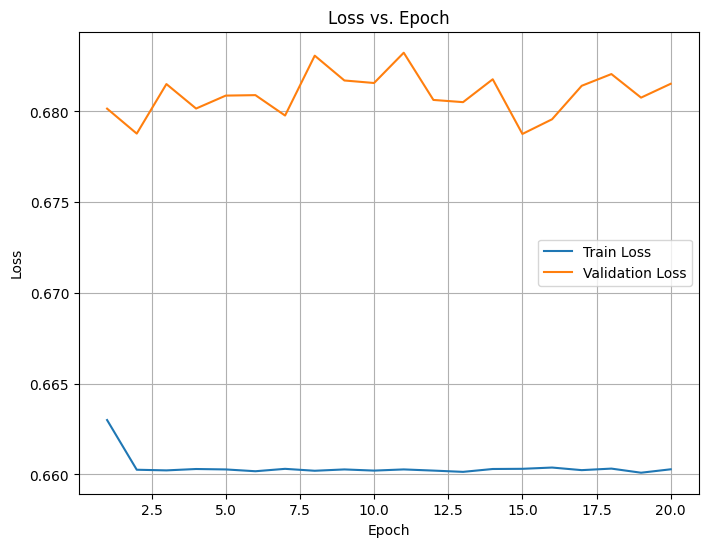

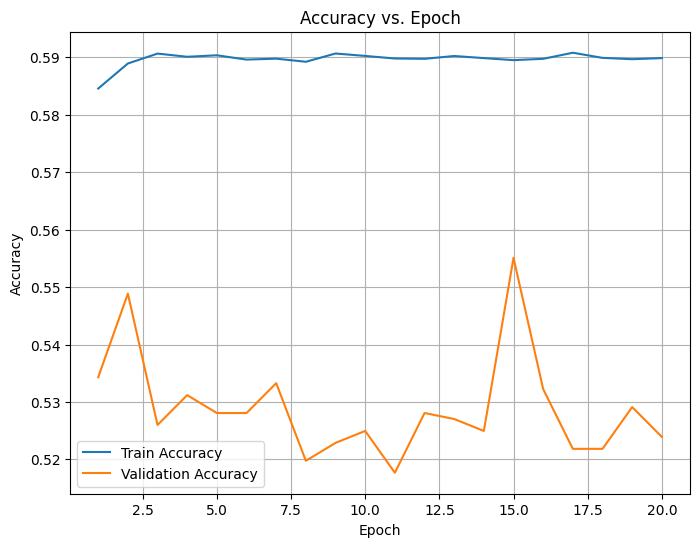

Test Loss: 0.6791, Test Accuracy: 0.5229
Final Test Performance -> Loss: 0.6791, Accuracy: 0.5229


In [ ]:
    model1, train_losses, train_accuracies, val_losses, val_accuracies, data_manager = train_log_linear_with_one_hot()
    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)
    test_loss, test_acc = report_test_performance(model1, data_manager)
    print(f"Final Test Performance -> Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

In [ ]:
vals = evaluate_special_subsets(model1, data_manager)

Evaluating special subsets...
Negated Polarity Subset - Loss: 0.7005, Accuracy: 0.4839
Rare Words Subset - Loss: 0.7411, Accuracy: 0.2800


***Running w2v log-linear model***

[==================================================] 100.0% 1662.8/1662.8MB downloaded
0
Loaded vocab size 3000000
[Epoch 1/20] Train Loss: 0.5299, Train Acc: 0.7777 | Val Loss: 0.5433, Val Acc: 0.7921
[Epoch 2/20] Train Loss: 0.4329, Train Acc: 0.8301 | Val Loss: 0.5123, Val Acc: 0.7942
[Epoch 3/20] Train Loss: 0.4107, Train Acc: 0.8352 | Val Loss: 0.5022, Val Acc: 0.7931
[Epoch 4/20] Train Loss: 0.4029, Train Acc: 0.8374 | Val Loss: 0.4977, Val Acc: 0.7942
[Epoch 5/20] Train Loss: 0.3996, Train Acc: 0.8391 | Val Loss: 0.4954, Val Acc: 0.7994
[Epoch 6/20] Train Loss: 0.3983, Train Acc: 0.8401 | Val Loss: 0.4951, Val Acc: 0.7963
[Epoch 7/20] Train Loss: 0.3973, Train Acc: 0.8401 | Val Loss: 0.4962, Val Acc: 0.7921
[Epoch 8/20] Train Loss: 0.3971, Train Acc: 0.8409 | Val Loss: 0.4941, Val Acc: 0.7952
[Epoch 9/20] Train Loss: 0.3968, Train Acc: 0.8408 | Val Loss: 0.4970, Val Acc: 0.7911
[Epoch 10/20] Train Loss: 0.3967, Train Acc: 0.8411 | Val Loss: 0.4942, Val Acc: 0.7994
[Epoch 11/20] 

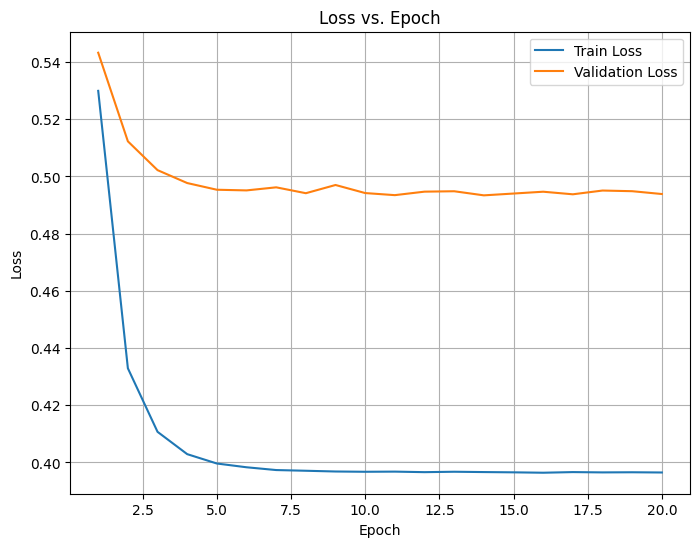

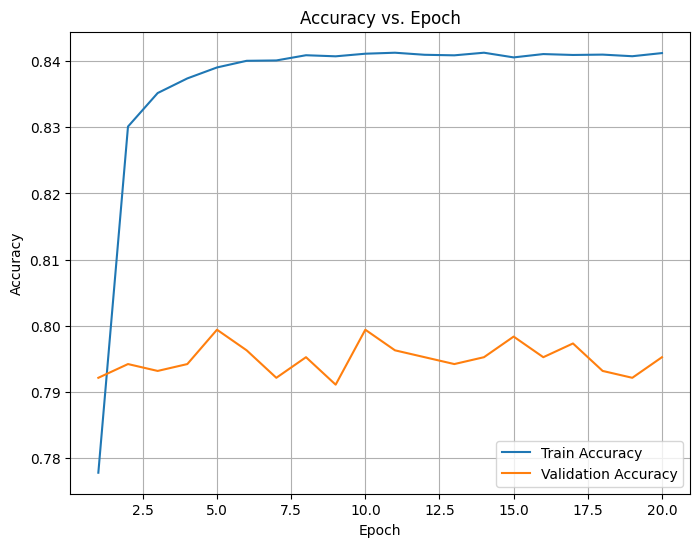

Test Loss: 0.4686, Test Accuracy: 0.8212
Final Test Performance -> Loss: 0.4686, Accuracy: 0.8212


In [ ]:
    model2, train_losses, train_accuracies, val_losses, val_accuracies, data_manager = train_log_linear_with_w2v()
    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)
    test_loss, test_acc = report_test_performance(model2, data_manager)
    print(f"Final Test Performance -> Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

In [ ]:
vals = evaluate_special_subsets(model2, data_manager)

Evaluating special subsets...
Negated Polarity Subset - Loss: 0.7507, Accuracy: 0.5806
Rare Words Subset - Loss: 0.6442, Accuracy: 0.7600


***Running w2v LSTM model***

0
Loaded vocab size 3000000
[Epoch 1/4] Train Loss: 0.3584, Train Acc: 0.8439 | Val Loss: 0.4193, Val Acc: 0.8191
[Epoch 2/4] Train Loss: 0.2906, Train Acc: 0.8797 | Val Loss: 0.4214, Val Acc: 0.8358
[Epoch 3/4] Train Loss: 0.2604, Train Acc: 0.8941 | Val Loss: 0.3935, Val Acc: 0.8274
[Epoch 4/4] Train Loss: 0.2372, Train Acc: 0.9052 | Val Loss: 0.3945, Val Acc: 0.8378
Model saved to /content/drive/MyDrive/CS/NLP/ex4/w2v_lstm.pth


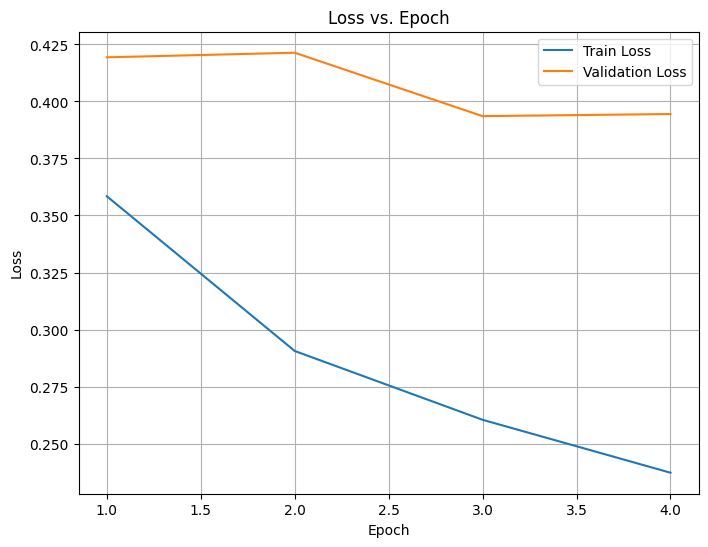

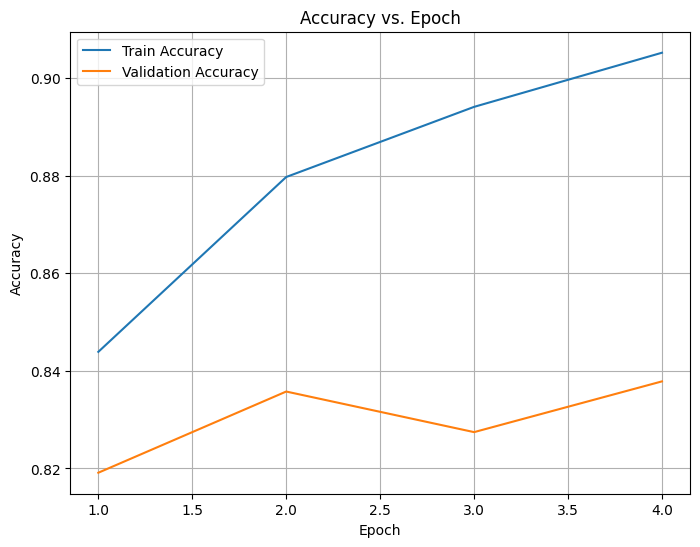

Test Loss: 0.3432, Test Accuracy: 0.8586
Final Test Performance -> Loss: 0.3432, Accuracy: 0.8586


In [ ]:
    model3, train_losses, train_accuracies, val_losses, val_accuracies, data_manager = train_lstm_with_w2v()
    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)
    test_loss, test_acc = report_test_performance(model3, data_manager)
    print(f"Final Test Performance -> Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

In [ ]:
vals = evaluate_special_subsets(model3, data_manager)

Evaluating special subsets...
Negated Polarity Subset - Loss: 0.8394, Accuracy: 0.6774
Rare Words Subset - Loss: 0.5597, Accuracy: 0.7800


***Running Transformer***

In [13]:
from transformers import RobertaTokenizer, DistilBertForSequenceClassification, AdamW, DistilBertTokenizer, DistilBertForSequenceClassification, RobertaForSequenceClassification

def train_transformer():
    """
    Code for training and evaluating a Transformer model using DistilRoBERTa.
    """
    # Load the tokenizer and model from HuggingFace Transformers
    tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base')
    model = RobertaForSequenceClassification.from_pretrained('distilroberta-base', num_labels=2)

    # Initialize the DataManager with full sentences as strings
    data_manager = DataManager(
        data_type=W2V_AVERAGE,  # Not using custom embeddings
        use_sub_phrases=False,  # Use only full sentences
        dataset_path="/content/drive/MyDrive/Colab Notebooks/stanfordSentimentTreebank",
        batch_size=16
    )

    def encode_sentences(sentences):
        """Helper function to encode sentences using the tokenizer."""
        return tokenizer(
            [" ".join(sent.text) for sent in sentences],
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

    # Encode the training, validation, and test datasets
    train_sentences = data_manager.sentences[TRAIN]
    val_sentences = data_manager.sentences[VAL]
    test_sentences = data_manager.sentences[TEST]

    train_encodings = encode_sentences(train_sentences)
    val_encodings = encode_sentences(val_sentences)
    test_encodings = encode_sentences(test_sentences)

    train_labels = torch.tensor([sent.sentiment_class for sent in train_sentences]).long()
    val_labels = torch.tensor([sent.sentiment_class for sent in val_sentences]).long()
    test_labels = torch.tensor([sent.sentiment_class for sent in test_sentences]).long()

    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
    val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)
    test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)
    test_loader = DataLoader(test_dataset, batch_size=16)

    # Define optimizer
    optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0)

    # Training loop
    device = get_available_device()
    model.to(device)

    n_epochs = 2
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch in train_loader:
            optimizer.zero_grad()
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            preds = torch.argmax(logits, dim=1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

        train_loss = total_loss / total_samples
        train_acc = correct_predictions / total_samples

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item() * labels.size(0)
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1}/{n_epochs}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # Test evaluation
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            test_loss += outputs.loss.item() * labels.size(0)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

    test_loss /= test_total
    test_acc = test_correct / test_total

    print(f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")
    return model, data_manager, tokenizer, 128, device

model, data_manager, tokenizer, max_len, device  = train_transformer()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[==================================================] 100.0% 1662.8/1662.8MB downloaded
0
Loaded vocab size 3000000


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/2: Train Loss=0.3490, Train Acc=0.8383, Val Loss=0.2564, Val Acc=0.9002
Epoch 2/2: Train Loss=0.2006, Train Acc=0.9207, Val Loss=0.2415, Val Acc=0.9064
Test Loss=0.2043, Test Acc=0.9116


In [19]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

def evaluate_special_subsets_transformer(model, data_manager, tokenizer, device, max_length=128):
    """
    Evaluate the given Transformer model (e.g., DistilRoBERTa) on special subsets
    like negated polarity examples and rare word examples.

    :param model: Trained Transformer model.
    :param data_manager: DataManager object to fetch datasets (and anything else you need).
    :param tokenizer: The Hugging Face tokenizer used for this model.
    :param device: The device on which we run the evaluation (CPU or GPU).
    :param max_length: The maximum sequence length for tokenization.
    """
    print("Evaluating special subsets...")

    # Access the SentimentTreeBank instance from your data manager
    sentiment_dataset = data_manager.sentiment_dataset

    # Retrieve the test set sentences (list of Sentence objects)
    test_sentences = sentiment_dataset.get_test_set()

    # We'll define small helpers to fetch the subset indices as you already have:
    negated_indices = get_negated_polarity_examples(test_sentences)
    rare_indices = get_rare_words_examples(test_sentences, sentiment_dataset)

    # -- Helper function to build a DataLoader for a subset of sentences --
    def create_subset_loader(indices, batch_size=32):
        subset_sentences = [test_sentences[i] for i in indices]
        texts = [" ".join(s.text) for s in subset_sentences]
        labels = [s.sentiment_class for s in subset_sentences]

        # Tokenize all sentences in one go
        inputs = tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )

        # Create a TensorDataset of (input_ids, attention_mask, labels)
        dataset = TensorDataset(
            inputs["input_ids"],
            inputs["attention_mask"],
            torch.tensor(labels, dtype=torch.long)
        )

        return DataLoader(dataset, batch_size=batch_size)

    # Build DataLoaders for each subset
    negated_loader = create_subset_loader(negated_indices)
    rare_loader = create_subset_loader(rare_indices)

    # Evaluate each subset
    negated_loss, negated_accuracy = evaluate_transformer_subset(model, negated_loader, device)
    print(f"Negated Polarity Subset - Loss: {negated_loss:.4f}, Accuracy: {negated_accuracy:.4f}")

    rare_loss, rare_accuracy = evaluate_transformer_subset(model, rare_loader, device)
    print(f"Rare Words Subset - Loss: {rare_loss:.4f}, Accuracy: {rare_accuracy:.4f}")

    return {
        "negated": {"loss": negated_loss, "accuracy": negated_accuracy},
        "rare_words": {"loss": rare_loss, "accuracy": rare_accuracy},
    }

def evaluate_transformer_subset(model, data_loader, device):
    """
    Evaluate the given model on a provided DataLoader containing (input_ids, attention_mask, labels).

    :param model: The Transformer model.
    :param data_loader: A DataLoader that yields (input_ids, attention_mask, labels).
    :param device: The device (CPU or GPU).
    :return: (average_loss, accuracy) on this subset.
    """
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    # No gradient needed during evaluation
    with torch.no_grad():
        for input_ids, attention_mask, labels in data_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            # Forward pass; the model returns a dict-like object with .loss and .logits
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            # Accumulate loss
            batch_size = labels.size(0)
            total_loss += loss.item() * batch_size

            # Compute accuracy
            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += batch_size

    avg_loss = total_loss / total_samples if total_samples > 0 else 0.0
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0
    return avg_loss, accuracy


In [20]:
evaluate_special_subsets_transformer(model, data_manager, tokenizer, device, max_length=128)

Evaluating special subsets...
Negated Polarity Subset - Loss: 0.4782, Accuracy: 0.7903
Rare Words Subset - Loss: 0.4110, Accuracy: 0.8400


{'negated': {'loss': 0.47823680600812357, 'accuracy': 0.7903225806451613},
 'rare_words': {'loss': 0.41099812746047976, 'accuracy': 0.84}}